In [1]:
#Loading the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize #########for outlier detection##########################
from sklearn.preprocessing import StandardScaler

In [2]:
#Importing the dataset
df_domestic = pd.read_csv('C:\\Users\\PCView\\Desktop\\Research_code\\Research-Models\\Data\\Domestic_Borrowing.csv')
df_domestic.head(10)

,Year,Domestic Borrowing
0,1990,13508.4
1,1991,16149.2
2,1992,15551.2
3,1993,24240.5
4,1994,37695.9
5,1995,33972.2
6,1996,49754.0
7,1997,30275.0
8,1998,71361.8
9,1999,74875.8


# 1. Exploring the dataset

In [3]:
df_domestic.shape

(32, 2)

In [4]:
df_domestic.isnull().sum()

Year                   0
Domestic  Borrowing    0
dtype: int64

In [5]:
df_domestic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 32 non-null     int64  
 1   Domestic  Borrowing  32 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 640.0 bytes


In [6]:
df_domestic.duplicated().sum()

0

* There are no duplicate records in the dataset.

In [7]:
#Selecting only the necessary columns
x = df_domestic['Year ']
x

0     1990
1     1991
2     1992
3     1993
4     1994
5     1995
6     1996
7     1997
8     1998
9     1999
10    2000
11    2001
12    2002
13    2003
14    2004
15    2005
16    2006
17    2007
18    2008
19    2009
20    2010
21    2011
22    2012
23    2013
24    2014
25    2015
26    2016
27    2017
28    2018
29    2019
30    2020
31    2021
Name: Year , dtype: int64

In [8]:
y = df_domestic['Domestic  Borrowing']
y

0     1.350840e+04
1     1.614920e+04
2     1.555120e+04
3     2.424050e+04
4     3.769590e+04
5     3.397220e+04
6     4.975400e+04
7     3.027500e+04
8     7.136180e+04
9     7.487580e+04
10    1.185000e+05
11    1.235950e+05
12    1.263510e+05
13    7.991100e+04
14    1.172432e+05
15    1.236040e+05
16    1.638045e+05
17    1.451373e+05
18    3.142870e+05
19    2.455540e+05
20    2.022290e+05
21    2.312240e+05
22    2.025110e+05
23    3.923900e+05
24    3.787210e+05
25    5.926991e+05
26    2.484110e+05
27    2.942510e+05
28    4.372338e+05
29    8.964480e+05
30    1.750887e+06
31    2.071826e+06
Name: Domestic  Borrowing, dtype: float64

# 2. Preprocessing

In [9]:
df_domestic.isnull().sum()

Year                   0
Domestic  Borrowing    0
dtype: int64

In [10]:
df_domestic.dtypes

Year                     int64
Domestic  Borrowing    float64
dtype: object

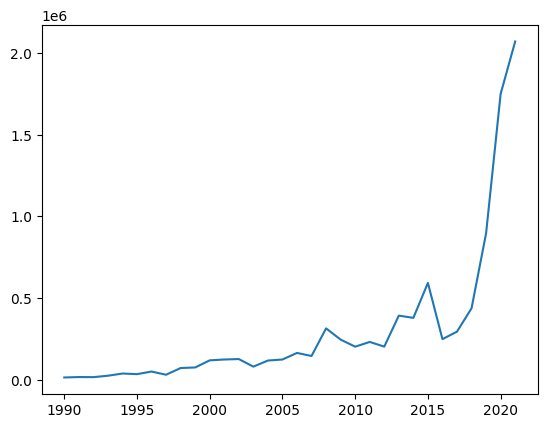

In [11]:
plt.plot(df_domestic['Year '],df_domestic['Domestic  Borrowing'])

* Since the columns from 1950 to 1995 doesnt have the real domestic values they are removed.

In [12]:
is_year_index = 'Year ' in df_domestic.index.names
print(is_year_index)

False


In [13]:
df_domestic.reset_index(inplace=True)

In [14]:
df_domestic.dtypes

index                    int64
Year                     int64
Domestic  Borrowing    float64
dtype: object

## 2.1 Quarterly Decomposing Data

In [15]:
#Converting the year column into datetime format
df_domestic['Year '] = pd.to_datetime(df_domestic['Year ' ], format='%Y')

#Setting the Year column as the index
df_domestic.set_index('Year ', inplace=True)

#Resampling the data to quarterly frequency and interpolate missing values
quarterly_data = df_domestic.resample('Q').mean().interpolate()

#Performaing seasonal decomposition
result = seasonal_decompose(quarterly_data['Domestic  Borrowing'], model='additive', period=4)

#Extracting the trend, seasonal, and residual components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

#Creating a dataframe with the decomposed components
quarterly_decomposition = pd.DataFrame({'Trend':trend,'Seasonal':seasonal,'Residual':residual})

#Adjust the seasonal component to have the same length as the original data
adjusted_seasonal = quarterly_decomposition['Seasonal'].repeat(1)[:len(quarterly_data)]

#Subtract the adjusted seasonal component from the original data
adjusted_data = quarterly_data['Domestic  Borrowing'] - adjusted_seasonal

#Creating a dataframe with the adjusted data
adjusted_quarterly_data = pd.DataFrame({'DomesticDebt_adjust':adjusted_data})

In [16]:
#Exporting the quarterly divided dataset
adjusted_quarterly_data.to_csv('C:\\Users\\PCView\\Desktop\\Research_code\\Research-Models\\Data\\quarter_data_domestic.csv')

# 3. Building the model

* First we are trying to fit the data to an ARIMA model but before fitting an ARIMA model we should check whether the data is stationary and whether the data exhibit any seasonality.

In [17]:
#Importing the quartely divided dataset
quarter_dom = pd.read_csv('C:\\Users\\PCView\\Desktop\\Research_code\\Research-Models\\Data\\quarter_data_domestic.csv')
quarter_dom.head(10)

,Year,DomesticDebt_adjust
0,1990-03-31,14337.301563
1,1990-06-30,14002.819688
2,1990-09-30,14331.459062
3,1990-12-31,15323.219687
4,1991-03-31,16978.101563
5,1991-06-30,15833.919688
6,1991-09-30,15352.859062
7,1991-12-31,15534.919687
8,1992-03-31,16380.101563
9,1992-06-30,17557.744688


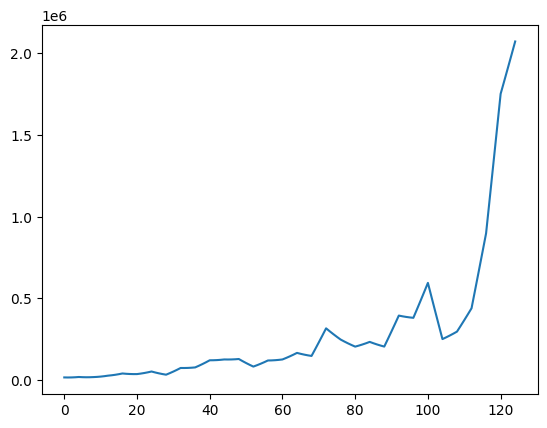

In [18]:
plt.plot(quarter_dom['DomesticDebt_adjust'])

## 3.1 Checking for statonarity of data

* To check for the data statinarity we will be using the Adfuller test.

**Hypothesis**

H0: Data is not stationary vs H1: Data is stationary.

In [19]:
#Performing the test
result = adfuller(quarter_dom['DomesticDebt_adjust'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.671737
p-value: 0.989257
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


* When p-value is greater than alpha(0.05) we do not reject H0.

* The result from the adfuller test is p-value(0.989345) which is greater than alpha(0.05) so we do not reject H0 at 5% significance level. Therefore we conclude that at 5% significance level we have enough evidence to conclude that the data is not stationary.

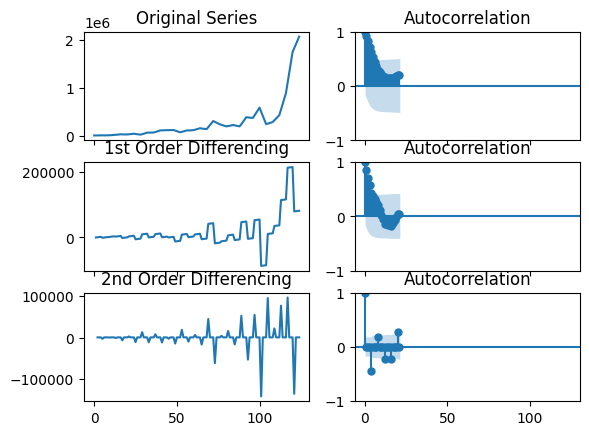

In [20]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(quarter_dom.DomesticDebt_adjust); axes[0, 0].set_title('Original Series')
plot_acf(quarter_dom.DomesticDebt_adjust, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(quarter_dom.DomesticDebt_adjust.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(quarter_dom.DomesticDebt_adjust.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(quarter_dom.DomesticDebt_adjust.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(quarter_dom.DomesticDebt_adjust.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
plt.show()

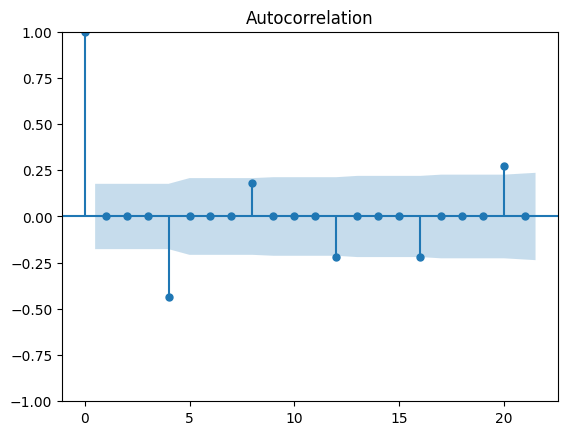

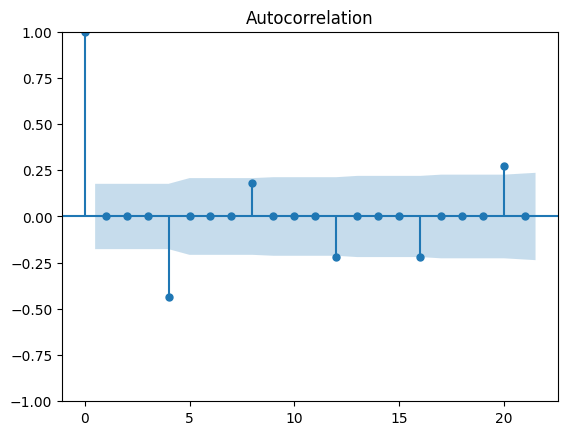

In [21]:
plot_acf(quarter_dom.DomesticDebt_adjust.diff().diff().dropna())

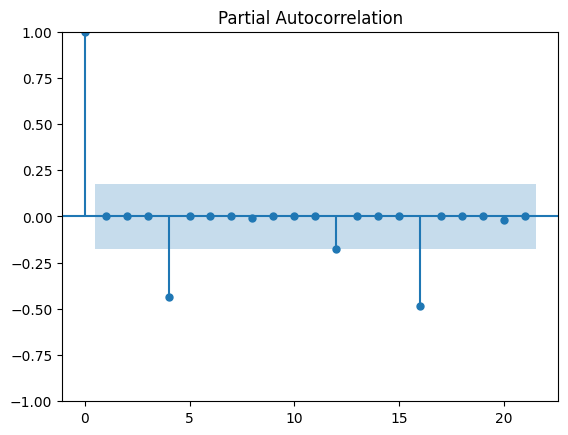

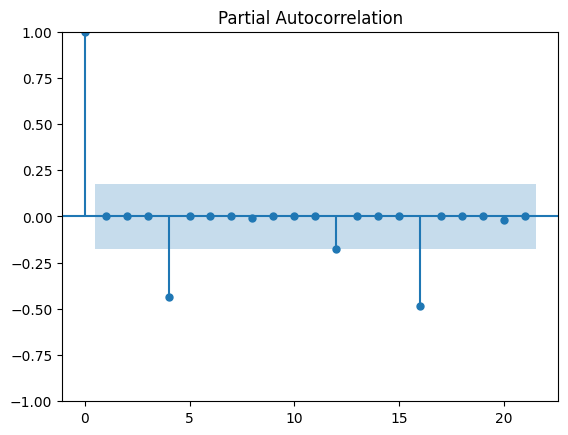

In [22]:
plot_pacf(quarter_dom.DomesticDebt_adjust.diff().diff().dropna())

c

## 3.2 Checking for seasonality in data

* To check for seasonality in the data we will use the seasonality plot.

# Perform seasonal decomposition using moving averages
decomposition = seasonal_decompose(quarter_dom['DomesticDebt_adjust'], model='multiplicative', period=12)

# Plot the seasonal decomposition
fig = decomposition.plot()

* There is a seasonal component in the dataset because we can see that the "Seasonal" graph from the above plots do not give a flat line.

* Since our data exhibits a seasonality we cannot use the ARIMA model.

* Next we will check whether we can use a SARIMA model to fit these data.

In [23]:
quarter_dom=quarter_dom.set_index('Year ')
is_year_index = 'Year ' in quarter_dom.index.names
print(is_year_index)

True


In [24]:
# Split the data into training and testing sets
train_data,test_data = train_test_split(quarter_dom, train_size=0.8,random_state=42)

In [25]:
# Standardize features
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.fit_transform(test_data)

### 3.2.1 SARIMA Model

#### 3.2.1.1 Finding the optimum parameters for SARIMA model

# Using auto_arima to find the optimum values
model = auto_arima(quarter_dom.DomesticDebt_adjust.diff().diff().dropna(), seasonal=True, m=4, trace=True)


# Get the recommended SARIMA parameters
order = model.order
seasonal_order = model.seasonal_order

print("Recommended SARIMA parameters:")
print("Order:", order)
print("Seasonal Order:", seasonal_order)

In [26]:
# Refit the SARIMAX model using the best parameters
p = 2
d = 2
q = 1
#model = sm.tsa.SARIMAX(train_scaled, order=order, seasonal_order=seasonal_order)
model = ARIMA(train_scaled, order=(p, d, q))

ARIMA_model = model.fit()

In [27]:
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -155.601
Date:                Mon, 30 Oct 2023   AIC                            319.202
Time:                        10:22:15   BIC                            329.542
Sample:                             0   HQIC                           323.384
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8007      0.084     -9.564      0.000      -0.965      -0.637
ar.L2         -0.4069      0.069     -5.867      0.000      -0.543      -0.271
ma.L1         -0.9998     16.687     -0.060      0.9

In [28]:
#df_domestic = df_domestic.set_index('Year')

#### 3.2.1.2 Making predictions to check model accuracy

In [29]:
#Making predcitions and checking the model accuracy
forecast = ARIMA_model.get_forecast(steps=len(test_scaled))
forecast

In [30]:
# Convert the forecast to a NumPy array or pandas Series
forecast_values = forecast.predicted_mean
forecast_values

array([-0.00278543, -0.05261632,  0.13343462,  0.01631607,  0.04595667,
        0.08145675,  0.05254434,  0.07282238,  0.07992523,  0.07756029,
        0.08813757,  0.0922048 ,  0.09621801,  0.10292362,  0.10749541,
        0.11268013,  0.11824239,  0.12325294,  0.1285516 ,  0.13384409,
        0.13902427,  0.14429689,  0.1495412 ,  0.15477056,  0.16002341])

In [31]:
#y_predictions_original_scale = scaler.inverse_transform([forecast])

In [32]:
#y_predictions_original_scale

In [33]:
test_scaled.shape

(25, 1)

In [34]:
test_scaled

array([[-0.57301368],
       [-0.36705489],
       [-0.47544525],
       [-0.06292027],
       [-0.44312166],
       [ 0.17484137],
       [-0.37304429],
       [ 4.15480432],
       [ 0.28131517],
       [-0.61738598],
       [-0.57387833],
       [ 1.51027438],
       [-0.35769215],
       [ 0.25894106],
       [-0.57446233],
       [-0.09150325],
       [-0.61153592],
       [ 0.56568282],
       [-0.60548409],
       [ 0.95211426],
       [-0.35510038],
       [-0.11848349],
       [-0.62376873],
       [-0.56290964],
       [-0.51116906]])

* The full dataset was used to make predictions to find the model accuracy.

In [35]:
forecast_values.reshape(-1, 1)

array([[-0.00278543],
       [-0.05261632],
       [ 0.13343462],
       [ 0.01631607],
       [ 0.04595667],
       [ 0.08145675],
       [ 0.05254434],
       [ 0.07282238],
       [ 0.07992523],
       [ 0.07756029],
       [ 0.08813757],
       [ 0.0922048 ],
       [ 0.09621801],
       [ 0.10292362],
       [ 0.10749541],
       [ 0.11268013],
       [ 0.11824239],
       [ 0.12325294],
       [ 0.1285516 ],
       [ 0.13384409],
       [ 0.13902427],
       [ 0.14429689],
       [ 0.1495412 ],
       [ 0.15477056],
       [ 0.16002341]])

In [36]:
forecast_values.shape

(25,)

In [37]:
test_scaled

array([[-0.57301368],
       [-0.36705489],
       [-0.47544525],
       [-0.06292027],
       [-0.44312166],
       [ 0.17484137],
       [-0.37304429],
       [ 4.15480432],
       [ 0.28131517],
       [-0.61738598],
       [-0.57387833],
       [ 1.51027438],
       [-0.35769215],
       [ 0.25894106],
       [-0.57446233],
       [-0.09150325],
       [-0.61153592],
       [ 0.56568282],
       [-0.60548409],
       [ 0.95211426],
       [-0.35510038],
       [-0.11848349],
       [-0.62376873],
       [-0.56290964],
       [-0.51116906]])

In [38]:
#Calculating the mean absolute error (MAE)
mae = mean_absolute_error(test_scaled, forecast_values)

#Calculating the mean squared error (MSE)
mse = mean_squared_error(test_scaled, forecast_values)

#Calculating the root mean squared error (RMSE)
rmse = np.sqrt(mse)

#Calculating the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((test_scaled - forecast_values) / test_scaled)) * 100


# Printing the calculated metrics
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)

MAE: 0.6711563480835078
MSE: 1.0166389396963487
RMSE: 1.0082851480094055
MAPE: 118.56481355389275


#### 3.2.1.3 Making predictions from the SARIMA model

In [39]:
# Making predictions
start_date = '2021'
end_date = '2028'
date_range = pd.date_range(start=start_date, end=end_date,freq='Q')
forecast1 = ARIMA_model.forecast(steps=len(date_range))
forecast1

array([-0.00278543, -0.05261632,  0.13343462,  0.01631607,  0.04595667,
        0.08145675,  0.05254434,  0.07282238,  0.07992523,  0.07756029,
        0.08813757,  0.0922048 ,  0.09621801,  0.10292362,  0.10749541,
        0.11268013,  0.11824239,  0.12325294,  0.1285516 ,  0.13384409,
        0.13902427,  0.14429689,  0.1495412 ,  0.15477056,  0.16002341,
        0.16526354,  0.17050429,  0.17574972])

In [40]:
original_predictions = scaler.inverse_transform([forecast1])
original_predictions

array([[271263.10890698, 250646.06266294, 327622.83123309,
        279166.16771787, 291429.6785349 , 306117.48970724,
        294155.26198324, 302545.10356734, 305483.8373946 ,
        304505.36971025, 308881.61514972, 310564.39075404,
        312224.82033449, 314999.19817916, 316890.73487653,
        319035.85947846, 321337.19241243, 323410.25715442,
        325602.52944566, 327792.24203605, 329935.49494438,
        332116.98957688, 334286.77007257, 336450.36830007,
        338623.6834911 , 340791.73409927, 342960.0459084 ,
        345130.29089585]])